In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas  as pd
import numpy   as np
import os
import re
import itertools
from scipy.spatial.distance import squareform

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [2]:
eggNOG_groups = pd.read_csv('2157_members.tsv',
                            sep='\t',
                            header=None,
                            usecols=[1,2,3,4],
                            names=['group_id', 'num_proteins', 'num_taxa', 'members'])

tmp           = eggNOG_groups.members.map(lambda cell: [int(taxid) 
                                                        for taxid in re.findall('(\d+)\.(?:[^,]+)', cell)])
tmp.name      = 'taxa'
eggNOG_groups = eggNOG_groups.join(tmp)

In [19]:
single_copy = eggNOG_groups.query('(num_proteins==num_taxa) &'
                                  '(num_taxa >= 100)').shape

In [5]:
jaccard_dists = []
for index1, index2 in itertools.combinations(single_copy.index, 2):
    jaccard_dists.append(
        len(set(single_copy.loc[index1, 'taxa']).intersection(single_copy.loc[index2, 'taxa'])) /\
        len(set(single_copy.loc[index1, 'taxa']).union(       single_copy.loc[index2, 'taxa']))
    )

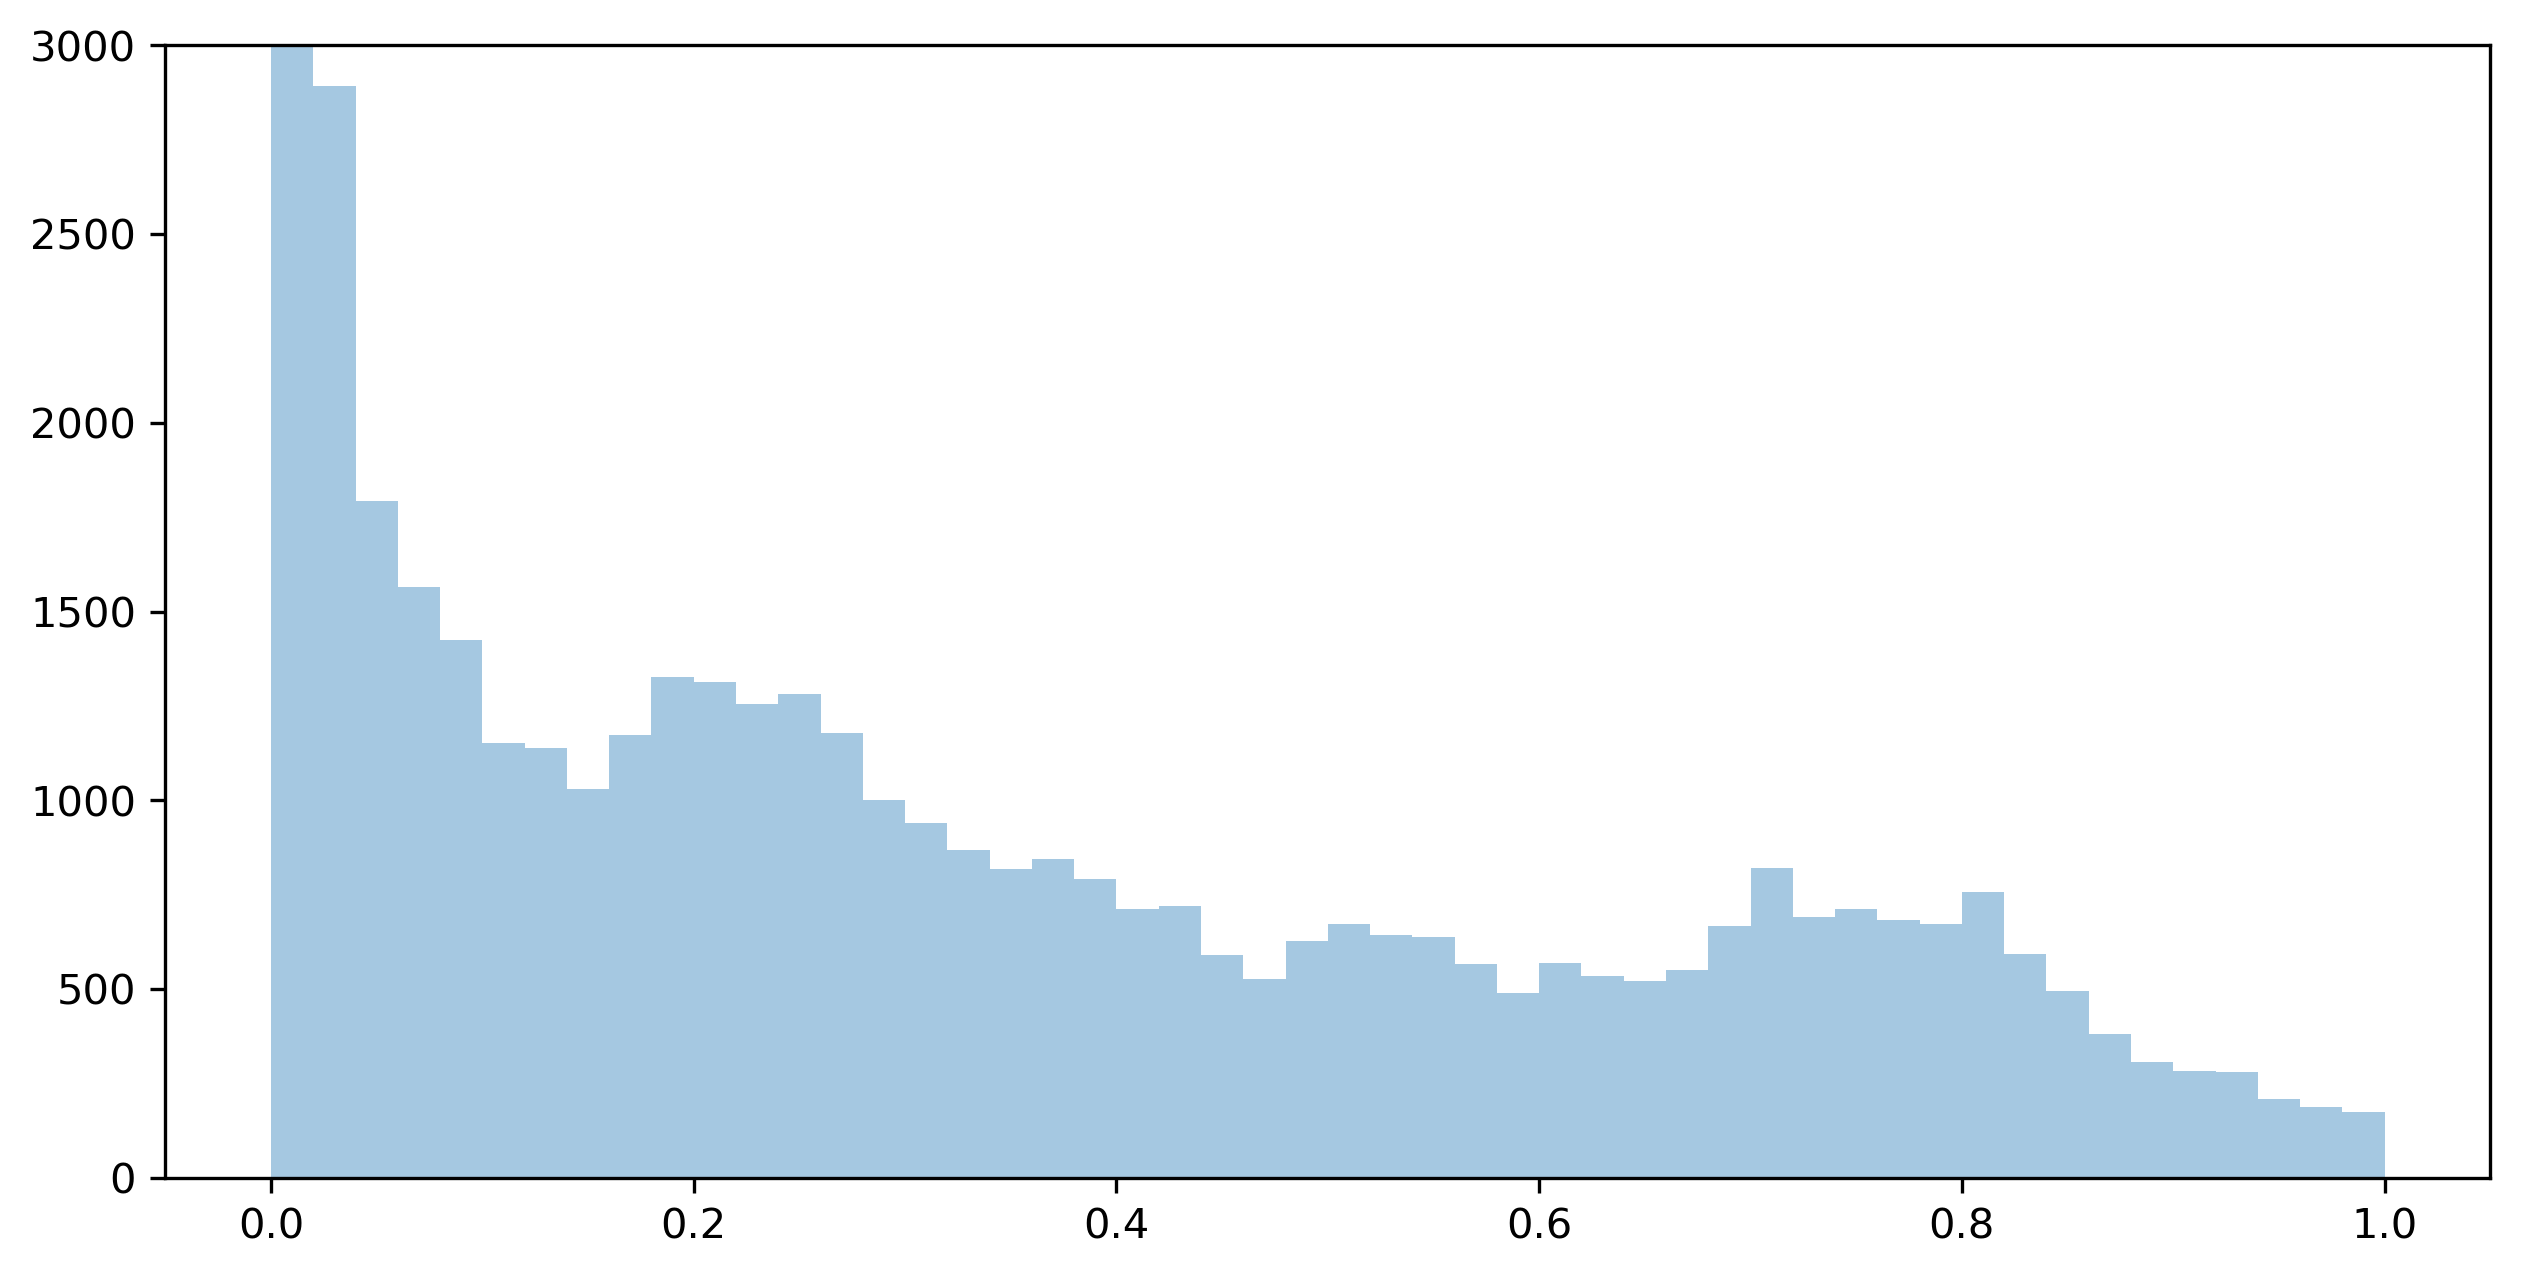

In [9]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.distplot(jaccard_dists, kde=False, ax=ax)
ax.set_ylim(0, 3_000);

In [39]:
jaccard_df = pd.DataFrame(data   =squareform(jaccard_dists),
                          index  =single_copy.index,
                          columns=single_copy.index)

num_compatibilities = (jaccard_df >= 0.8).sum()
num_compatibilities = num_compatibilities[num_compatibilities >= 5]

jaccard_df = jaccard_df.reindex(index  =num_compatibilities.index,
                                columns=num_compatibilities.index)

jaccard_df.rename(index=index2id, 
                  columns=index2id, 
                  inplace=True)

jaccard_df.to_csv('jaccard_dists_between_single_copies.tsv', sep='\t')

In [22]:
jaccard_df.head()

,2Z7MA,2Z7RA,2Z7WE,2Z7YX,2Z805,2Z82N,2Z84M,2Z86M,2Z89M,2Z8IN,...,3475H,347NM,34804,3487A,348QT,348T2,349V5,34A2I,34AS9,COG3820
2Z7MA,0.000000,0.0,0.0,0.0,0.746575,0.658163,0.000000,0.000000,0.880000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2Z7RA,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.804196,0.000000,0.783217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2Z7WE,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.970874,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176776
2Z7YX,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.804196,0.000000,0.783217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2Z805,0.746575,0.0,0.0,0.0,0.000000,0.591160,0.000000,0.000000,0.801471,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [30]:
triu_indices           = np.triu_indices_from(jaccard_df, k=1)

edge_list              = pd.DataFrame()
edge_list['group_id1'] = jaccard_df.index[ triu_indices[0]]
edge_list['group_id2'] = jaccard_df.index[ triu_indices[1]]
edge_list['jaccard' ]  = jaccard_df.values[triu_indices]

In [35]:
eggNOG_trees = pd.read_csv('/work/eggNOG/2_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=jaccard_df.index)

In [63]:
if not os.path.isdir('trees/'):
    os.mkdir('trees/')
    
for index, row in eggNOG_trees.iterrows():
    with open(f'trees/{index}.nwk', 'w') as out:
        out.write(re.sub('([(),]\d+)\.[^:]+', r'\1', row.tree))

In [75]:
if not os.path.isdir('alignments/'):
    os.mkdir('alignments/')

for group_id in jaccard_df.index:
    with open(f'alignments/{group_id}.fas', 'w') as out:
        for taxon in eggNOG_groups.query(f'group_id=="{group_id}"')['taxa'].squeeze():
            out.write(f'>{taxon}\n-\n')